# Energy Price Characteristics

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_optim
from statsmodels.tsa.stattools import pacf
from sklearn.metrics import r2_score
from arch import arch_model

In [13]:
# Load data
datasets = {}
for hour in range(24): # 24
    datasets[hour] = pd.read_csv(f"Splits/dataset_hour_{hour}.csv")

datasets_train = {hour: datasets[hour][(datasets[hour]['DATE'] >= '2014-01-01') & (datasets[hour]['DATE'] < '2023-01-01')].drop(['DATE'], axis=1).to_numpy() for hour in range(24)}
datasets_test = {hour: datasets[hour][datasets[hour]['DATE'] >= '2023-01-01'].drop(['DATE'], axis=1).to_numpy() for hour in range(24)}

y_train = {hour: datasets_train[hour][:, 0].reshape(-1, 1) for hour in range(24)}
y_test = {hour: datasets_test[hour][:, 0].reshape(-1, 1) for hour in range(24)}

weather_train = {hour: datasets_train[hour][:, 1:-1] for hour in range(24)}
weather_test = {hour: datasets_test[hour][:, 1:-1] for hour in range(24)}

X = weather_train[0]
Y = y_train[0].ravel()

# Price Persistence and Long-Memory

Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF) with 95% Confidence Bounds')

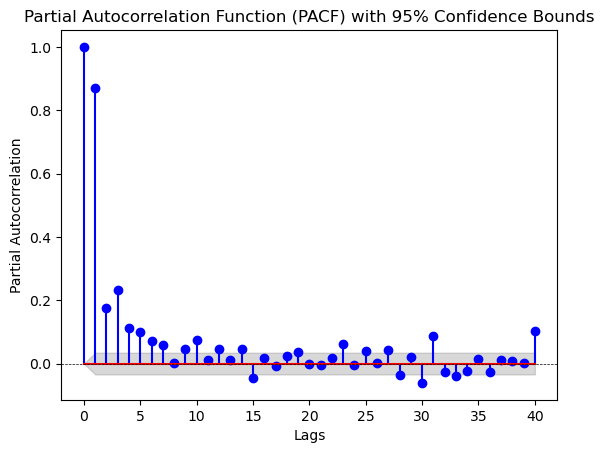

In [43]:
lags = 40
pacf_values, confint = pacf(Y, nlags=lags, alpha=0.05)

# Plot PACF with confidence bounds
fig, ax = plt.subplots()
ax.stem(range(lags + 1), pacf_values, linefmt='b-', markerfmt='bo', basefmt='r-')
ax.fill_between(range(lags + 1), confint[:, 0] - pacf_values, confint[:, 1] - pacf_values, color='gray', alpha=0.3)
ax.axhline(y=0, linestyle='--', color='black', linewidth=0.5)
ax.set_xlabel('Lags')
ax.set_ylabel('Partial Autocorrelation')
ax.set_title('Partial Autocorrelation Function (PACF) with 95% Confidence Bounds')


## Volatility Clustering

## Price Spikes


In [161]:
# Assuming Y is your time series data
Y_series = pd.Series(Y)
valid_indices = ~np.isnan(Y_series)
Y_series = Y_series[valid_indices]

# Calculate the differences (changes) in Y
Y_changes = Y_series.diff()

model = arch_model(Y_changes, vol='Garch', p=1, q=1)
fitted_model = model.fit()

# Get the conditional volatility (filtered values)
conditional_volatility = fitted_model.conditional_volatility

Z = Y_changes / conditional_volatility

# Calculate the mean and standard deviation of the changes
mean_Z = abs(Z .mean())
std_Z = Z.std()

n_std = 5 # You can adjust this value as needed
# Identify spikes in changes: values that are more than n times the standard deviation away from the mean
spike_condition = (Z > mean_Z + n_std * std_Z) | (Z < mean_Z - n_std * std_Z)

# Create a new array with spikes in changes and NaN elsewhere
price_spikes = Z.where(spike_condition, np.nan)

# Plot the original time series and the spikes based on changes
plt.figure(figsize=(12, 6))
plt.plot(Y_changes, label='Original Time Series', alpha=0.5)
plt.plot(Z.index, Z[price_spikes.index], 'ro', label='Price Change Spikes', markersize=4)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Energy Price Data with Spikes Based on Changes')
plt.legend()
plt.grid(True)
plt.show()

ValueError: NaN or inf values found in y. y must contains only finite values.

## Time-Varying Mean

## Volatility-Conditional Mean

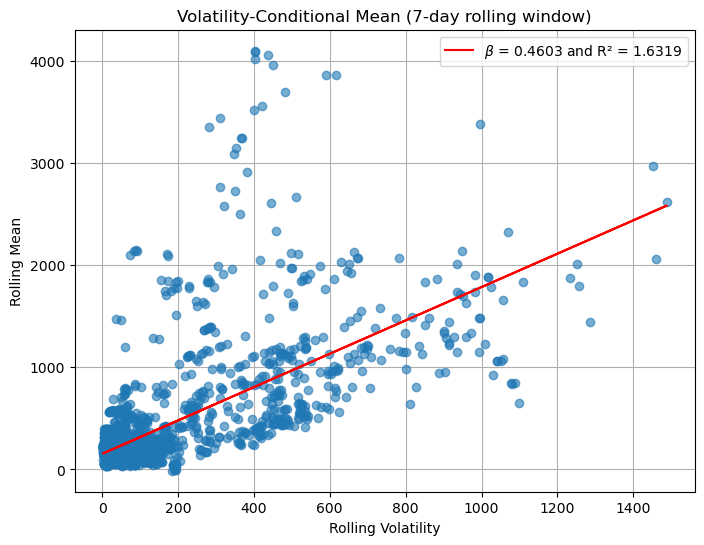

In [111]:
Y_series = pd.Series(Y)
rolling_window = 7
rolling_avg = Y_series.rolling(window=rolling_window).mean()
rolling_volatility = Y_series.rolling(window=rolling_window).std()

# Remove NaN values that result from the rolling calculation
valid_indices = ~np.isnan(rolling_avg) & ~np.isnan(rolling_volatility)
rolling_avg = rolling_avg[valid_indices]
rolling_volatility = rolling_volatility[valid_indices]

# Fit a line to the data
coefficients = np.polyfit(rolling_volatility, rolling_avg, 1)
slope = coefficients[0]
linear_fit = np.poly1d(coefficients)

# Calculate R^2 value
predicted_avg = linear_fit(rolling_volatility)
r2 = r2_score(rolling_avg, predicted_avg)

plt.figure(figsize=(8, 6))
plt.plot(rolling_volatility, rolling_avg, 'o', alpha=0.6)
plt.plot(rolling_volatility, predicted_avg, 'r-', label=rf'$\beta$ = {r2:.4f} and R² = {slope:.4f}')
plt.xlabel('Rolling Volatility')
plt.ylabel('Rolling Mean')
plt.title(f'Volatility-Conditional Mean ({rolling_window}-day rolling window)')
plt.legend()
plt.grid(True)
plt.show()

## Seasonality

## Fat Tailed